In [1]:
# from MuyGPyS import config
# config.update("muygpys_jax_enabled", False)

import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from MuyGPyS.examples.classify import do_classify
from MuyGPyS.gp.deformation import F2, Isotropy, l2
from MuyGPyS.gp.hyperparameter import Parameter, Parameter as ScalarParam
from MuyGPyS.gp.kernels import RBF, Matern
from MuyGPyS.gp.noise import HomoscedasticNoise
from MuyGPyS.optimize import Bayes_optimize, OptimizeFn, L_BFGS_B_optimize
from MuyGPyS.optimize.loss import LossFn, cross_entropy_fn
from time import perf_counter



/home/eleh/miniconda3/envs/muygps/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:

# data_path = ['norm_11.csv','norm_1.csv', 'norm_21.csv', 'raw_image_data.csv']
data_path = [ 'norm_2.csv']
# get rid of "../data/data-norm/"
norm_data_names = data_path
norm_data_names

['norm_2.csv']

In [5]:
def generate_onehot_value(values):
    onehot = []
    for val in values:
        if val == 0:
            onehot.append([1., -1.])
        elif val == 1:
            onehot.append([-1., 1.])
    return onehot

In [6]:
nn_kwargs_exact = {"nn_method": "exact", "algorithm": "ball_tree"}

nn_kwargs_hnsw = {"nn_method": "hnsw"}

k_kwargs_rbf ={
            "kernel": RBF(
                 deformation=Isotropy(
                     metric=l2,
                 length_scale=Parameter(1.0, (1e-2, 1e2)),
                 ),
            ),
            "noise": HomoscedasticNoise(1e-5),
            }
k_kwargs_mattern= { "kernel": Matern(
             smoothness=ScalarParam(0.5),
             deformation=Isotropy(
                 metric=l2,
                 length_scale=Parameter(1.0, (1e-2, 1e2)),
             ),
         ),
         "noise": HomoscedasticNoise(1e-5),
         }

In [7]:
nn_counts = [5, 10, 15, 20,25,30,35,40 ]
batch_counts = [ 5,10,20,40,80,160,320,640]

In [6]:
now = perf_counter()
accuracies = {name: [] for name in nn_counts}

for nn in tqdm(nn_counts):
    for batch in tqdm(batch_counts):
        for path in norm_data_names:
            path1 = '../../data/data-norm/max-only/' + path
            data = pd.read_csv(path1,na_values='-')
            data.fillna(0,inplace=True)
            data_label = ''.join(path.split('.')[:2])
            truth_labels = data.iloc[:, 0].values
            image_data = data.iloc[:, 1:].values

            X_train, X_test, y_train, y_test = train_test_split(image_data, truth_labels, test_size=0.2, random_state=42)

            print("=============== ", data_label, " ===============")
            print('Training data:', len(y_train[y_train==0]), 'single stars and', len(y_train[y_train==1]), 'blended stars')
            print('Testing data:', len(y_test[y_test==0]), 'single stars and', len(y_test[y_test==1]), 'blended stars')

            onehot_train, onehot_test = generate_onehot_value(y_train), generate_onehot_value(y_test)

            train = {'input': X_train, 'output': onehot_train, 'lookup': y_train}
            test = {'input': X_test, 'output': onehot_test, 'lookup': y_test}

            print("Running Classifier on", data_label)
            #Switch verbose to True for more output


            muygps, nbrs_lookup, surrogate_predictions = do_classify(
                                        test_features=np.array(test['input']), 
                                        train_features=np.array(train['input']), 
                                        train_labels=np.array(train['output']), 
                                        nn_count=nn,
                                        batch_count=batch,
                                        loss_fn=cross_entropy_fn,
                                        opt_fn=Bayes_optimize,
                                        k_kwargs=k_kwargs_mattern,
                                        nn_kwargs=nn_kwargs_hnsw,
                                        verbose=False)
            predicted_labels = np.argmax(surrogate_predictions, axis=1)
            accur = np.around((np.sum(predicted_labels == np.argmax(test["output"], axis=1))/len(predicted_labels))*100, 3),
            accuracies[nn].append(accur[0])
            print("Total accuracy for", data_label, ":", accur[0], '%')

my_accuracies = pd.DataFrame(accuracies, index=batch_counts)
my_accuracies.to_csv('accuracies-nn-batch-counts.csv')
end = perf_counter()
print("Total time taken for Hyperparameter Optimization: ", (end-now)/60, "minutes")

  0%|          | 0/8 [00:00<?, ?it/s]

===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 79.563 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 79.527 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 79.582 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 79.747 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv
Data point [0.01] is not unique. 1 duplicates registered. Continuing ...
Data point [0.01] is not unique. 2 duplicates registered. Continuing ...
Data point [0.01] is not unique. 3 duplicates registered. Continuing ...
Data point [0.01] is not unique. 4 duplicates registered. Continuing ...
Data point [0.01] is not unique. 5 duplicates registered. Continuing ...
Data point [0.01] is not unique. 6 duplicates registered. Continuing ...
Data point [0.01] is not unique. 7 duplicates registered. Continuing ...
Data point [0.01] is not unique. 8 duplicates registered. Continuing ...
Data point [0.01] is not unique. 9 duplicates registered. Continuing ...
Data point [0.01] is not unique. 10 duplicates registered. Continuing ...
Data point [0.01] is not unique. 11 dupli

Total accuracy for norm_2csv : 77.839 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 79.784 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 79.728 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


 12%|█▎        | 1/8 [00:09<01:07,  9.65s/it]

Total accuracy for norm_2csv : 79.49 %


===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.141 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.031 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.343 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.49 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.49 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.49 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.288 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


 25%|██▌       | 2/8 [00:21<01:05, 10.87s/it]

Total accuracy for norm_2csv : 81.398 %


===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.545 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv
Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...


Total accuracy for norm_2csv : 81.82 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.618 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.058 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.113 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.875 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.765 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


 38%|███▊      | 3/8 [00:37<01:05, 13.08s/it]

Total accuracy for norm_2csv : 81.93 %


===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.499 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 81.691 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.315 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.003 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.058 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.077 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.132 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


 50%|█████     | 4/8 [00:56<01:01, 15.42s/it]

Total accuracy for norm_2csv : 81.765 %


===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.168 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.554 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.921 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.205 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.022 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.572 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.407 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


 62%|██████▎   | 5/8 [01:21<00:56, 18.91s/it]

Total accuracy for norm_2csv : 82.499 %


===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.829 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.223 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 83.049 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.902 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.737 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.7 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.664 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


 75%|███████▌  | 6/8 [01:52<00:46, 23.27s/it]

Total accuracy for norm_2csv : 82.682 %


===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.37 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.719 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.37 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.407 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.737 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.774 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.81 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


 88%|████████▊ | 7/8 [02:32<00:28, 28.59s/it]

Total accuracy for norm_2csv : 82.737 %


===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.902 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.297 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv
Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...


Total accuracy for norm_2csv : 82.37 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.921 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.957 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.902 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


Total accuracy for norm_2csv : 82.884 %
===============  norm_2csv  ===============
Training data: 12073 single stars and 9728 blended stars
Testing data: 3036 single stars and 2415 blended stars
Running Classifier on norm_2csv


100%|██████████| 8/8 [03:22<00:00, 25.34s/it]

Total accuracy for norm_2csv : 82.81 %
Total time taken for Hyperparameter Optimization:  3.3789038850499007 minutes


In [8]:
results = pd.read_csv('accuracies-nn-batch-counts.csv', index_col=0)
results


,5,10,15,20,25,30,35,40
5,79.563,81.141,81.545,82.499,82.168,82.829,82.370,82.902
10,79.527,81.031,81.820,81.691,82.554,82.223,82.719,82.297
20,79.582,81.343,81.618,82.315,82.921,83.049,82.370,82.370
40,79.747,81.490,82.058,82.003,82.205,82.902,82.407,82.921
80,77.839,81.490,82.113,82.058,82.022,82.737,82.737,82.957
160,79.784,81.490,81.875,82.077,82.572,82.700,82.774,82.902
320,79.728,81.288,81.765,82.132,82.407,82.664,82.810,82.884
640,79.490,81.398,81.930,81.765,82.499,82.682,82.737,82.810


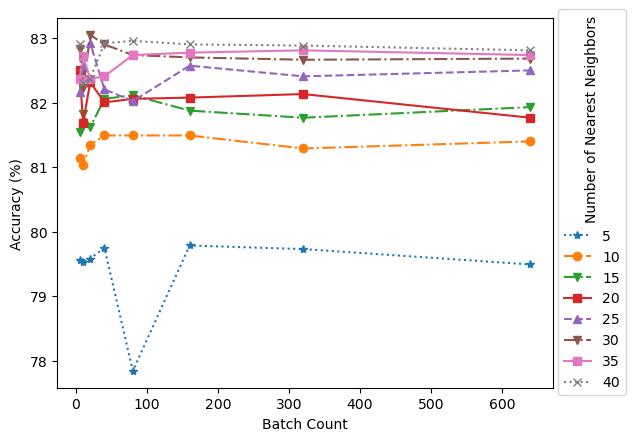

In [9]:
import random
# list of matplotlib linestyles
linestyles = ['-', '--', '-.', ':']
# list of line markers
markers = ['o', 'v', '^', 's', 'p', '*', '+', 'x']
ncols = len(results.columns)
for i in range(ncols):
    plt.plot(results.iloc[:, i], marker=random.choice(markers), linestyle=random.choice(linestyles))

# results.plot( marker='^', linestyle='--')
plt.xlabel('Batch Count')
plt.ylabel('Accuracy (%)')
# plt.title('Accuracy vs Batch Count for Different NN Counts')
plt.legend(title='Number of Nearest Neighbors', loc='lower right', labels=nn_counts)
# position the title of the legend vertically
plt.gcf().get_axes()[0].get_legend().get_title().set_rotation(90)
# put the legend title on right side of legends
plt.gcf().get_axes()[0].get_legend().get_title().set_ha('left')
# move the legend to the right side
plt.gcf().get_axes()[0].get_legend()._set_loc((1.01,-0.02))
plt.savefig('batch_nn_counts_accuracy.pdf', format='pdf', bbox_inches='tight')


In [10]:
# # list of matplotlib linestyles
# linestyles = ['-', '--', '-.', ':']
# # list of line markers
# markers = ['o', 'v', '^', 's', 'p', '*', '+', 'x']